CHECK README

# Segmentation of Medical Scans using Variational VAE's
This notebook goes through the process of creating a pytorch-compatible dataset, and setting up a model for segmentation of tumors in various organs. It enables reproduceability of our final model and testing results.

## 1. Setup
We import some necessary libraries

In [1]:
# For ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torch import Tensor
import torchvision.transforms as Transform
from torch.utils.data import Dataset

# For reading raw data.
import json
import nibabel as nib

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# For monitoring resource-usage and progress.
from timeit import default_timer as timer
from tqdm import tqdm # Install ipywidgets to remove warning.
import os, sys, psutil
from os.path import join, exists

c:\Users\dfels\anaconda3\envs\torch_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large.

In [2]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce RTX 2060 with Max-Q Design
CUDA version: 11.7
RAM: 33.74GB


We setup up some global constants.

In [3]:
root_dir = '../' # Location of project, relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')
cmap_seg = ListedColormap(['none', 'red']) # For drawing tumors in red.

And some utility functions.

In [4]:
def superimpose(image, label):
    plt.imshow(torch.squeeze(image), cmap='gray')
    plt.imshow(torch.squeeze(image), cmap=cmap_seg)
    plt.show()

def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    axs[0].imshow(img_0, vmin=0, vmax=1, cmap='gray')
    axs[1].imshow(img_1, vmin=0, vmax=1, cmap='gray')
    fig.canvas.draw()

In [5]:
def list_checkpoints(dir):
    epochs = []
    for name in os.listdir(dir):
        if os.path.splitext(name)[-1] == '.pth':
            epochs += [int(name.strip('ckpt_.pth'))]
    return epochs

def save_checkpoint(dir, epoch, model, optimizer=None):
    checkpoint = {}; checkpoint['epoch'] = epoch

    if isinstance(model, torch.nn.DataParallel):
        checkpoint['model'] = model.module.state_dict()
    else:
        checkpoint['model'] = model.state_dict()

    if optimizer is not None:
        checkpoint['optimizer'] = optimizer.state_dict()
    else:
        checkpoint['optimizer'] = None

    torch.save(checkpoint, os.path.join(dir, 'ckpt_%02d.pth'% epoch))

def load_checkpoint(dir, epoch=0):
    if epoch == 0: epoch = max(list_checkpoints(dir))
    checkpoint_path = os.path.join(dir, 'ckpt_%02d.pth'% epoch)
    return torch.load(checkpoint_path, map_location='cpu')

def load_model(dir, model, epoch=0):
    ckpt = load_checkpoint(dir, epoch)
    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(ckpt['model'])
    else:
        model.load_state_dict(ckpt['model'])
    return model

def load_optimizer(dir, optimizer, epoch=0):
    ckpt = load_checkpoint(dir, epoch)
    optimizer.load_state_dict(ckpt['optimizer'])
    return optimizer

We preprocess and format datasets from raw data for each specified organ, using the above function. We save progress after each organ is completed. Can be interrupted and resumed at any time, and accounts for progress, which has already been made. We define a function which loads and stores our data in the proper formatting. As the datasets are huge and have to concatenate each set of 240 slices to the previous, we monitor progress and RAM-usage.

In [6]:
def prep_data(organ, type, resolution):
    with open(join(raw_data_dir, organ, 'dataset.json')) as f:
        manifest = json.load(f)['training']
    
    bar = tqdm(total=len(manifest))
    bar.set_description('Prepping ' + organ + ' ' + type + 's')
    
    resize = Transform.Resize((resolution, resolution))

    try: 
        images = torch.zeros((0, resolution, resolution))

        for entry in manifest:
            bar.set_postfix(**{'RAM':round(psutil.virtual_memory()[3]/10e8, 2)})
            bar.update()

            nii_img = nib.load(join(raw_data_dir, organ, entry[type][2:]))

            # Convert to numpy array, then pytorch tensor.
            nii_data = Tensor(nii_img.get_fdata())
            
            # Scale between 0 and 1. Try -1 and 1?
            nii_data -= nii_data.min()
            nii_data /= nii_data.max()

            nii_data = nii_data.permute(2, 0, 1) # (slice, rows, columns)
            nii_data = resize(nii_data)
            images = torch.cat((images, nii_data), 0)
        
        torch.save(images, join(prep_data_dir, organ + '_' + type + '_slices_' + str(resolution) + '.pt'))

    except KeyboardInterrupt:
        print('Manually stopped.')
    
    bar.close()

We call the preprocessor function for the organs, we wish to train on.

In [7]:
lod = 2**8                 # Level of detail.
resolution = lod           # 2**8 = 256
do_prep = False            # Toggle to prep data.

organs = ['spleen'] #,'colon','pancreas','lung','liver']

if do_prep:
    for organ in organs:
        prep_data(organ,'image',resolution)
        prep_data(organ,'label',resolution)
else:
    print('Data already prepped.')

Data already prepped.


## 2. Managing data
We define a custom dataset class.

In [8]:
class CT_Dataset(Dataset):
    def __init__(self, path, organ, resolution):
        self.images = torch.load(join(path, organ + '_image_slices_' + str(resolution) + '.pt'))
        
        self.labels = torch.load(join(path, organ + '_label_slices_' + str(resolution) + '.pt'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # Adding channel dimension.
        return image[None, :], label[None, :]

    def show_datapoint(self, index):
        image, label = self.__getitem__(index)
        superimpose(image, label)

And create a function, which will split a dataset and create appropriate dataloaders.

In [9]:
def make_loaders(data, batch_size):
    N = len(data); N_t = int(0.9*N); N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

We check if the dataset functions directly by retrieving and displaying a single datapoint. One must specify the organ and the resolution of the images.

## 3. Defining our model architecture
We define the variational encoder architecture as a pytorch module.

In [10]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)
    
class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvTranspose, self).__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)

class VAEModel(nn.Module):
    def __init__(self, base):
        super(VAEModel, self).__init__()
        
        self.encoder = nn.Sequential(
            Conv(1, base, 3, stride=2, padding=1),
            Conv(base, 2*base, 3, padding=1),
            Conv(2*base, 2*base, 3, stride=2, padding=1),
            Conv(2*base, 2*base, 3, padding=1),
            Conv(2*base, 2*base, 3, stride=2, padding=1),
            Conv(2*base, 4*base, 3, padding=1),
            Conv(4*base, 4*base, 3, stride=2, padding=1),
            Conv(4*base, 4*base, 3, padding=1),
            Conv(4*base, 4*base, 3, stride=2, padding=1),
            nn.Conv2d(4*base, 64*base, 8),
            nn.LeakyReLU()
        )
        self.encoder_mu = nn.Conv2d(64*base, 32*base, 1)
        self.encoder_logvar = nn.Conv2d(64*base, 32*base, 1)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32*base, 64*base, 1),
            ConvTranspose(64*base, 4*base, 8),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 4, stride=2, padding=1),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 4, stride=2, padding=1),
            Conv(4*base, 2*base, 3, padding=1),
            ConvTranspose(2*base, 2*base, 4, stride=2, padding=1),
            Conv(2*base, 2*base, 3, padding=1),
            ConvTranspose(2*base, 2*base, 4, stride=2, padding=1),
            Conv(2*base, base, 3, padding=1),
            ConvTranspose(base, base, 4, stride=2, padding=1),
            nn.Conv2d(base, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def encode(self, x):
        x = self.encoder(x)
        return self.encoder_mu(x), self.encoder_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def forward_latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

## 4. Setting up a training environment

We define a custom loss function, which combines binary-cross-entropy loss and Kullback–Leibler divergence.

In [11]:
def loss_fn(batch, recon, mu, log_var):
    recon_loss = nn.BCELoss(reduction='mean')
    kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))
    return recon_loss(recon, batch) + 0.1 * kld

We define a training routine for a single epoch, i.e. a full round of training data.

In [12]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    losses = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        losses += loss.item()   
    return losses / len(train_loader)  # average loss

And an evaluation routine.

In [13]:
def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

## 5. Putting it all together  

We create an instance of the CT_Dataset, specifying the organ, on which we wish to train our model. This set is passed onto the dataloaders. Be careful with running this, as the dataset variable will take up a lot of space in RAM.

In [14]:
resolution = 2**8
batch_size = 32;
dataset = CT_Dataset(prep_data_dir, 'lung', resolution)
train_loader, dev_loader = make_loaders(dataset, batch_size)

We inspect a datapoint directly and from one of the dataloaders to make sure everything works as expected.

In [15]:
image, label = dataset.__getitem__(1)
print(np.shape(image))
batch = next(iter(train_loader))
print(np.shape(batch[0]))

torch.Size([1, 256, 256])
torch.Size([32, 1, 256, 256])


We use our previously defined class to create an instance of our model. We specify the optimizer, as well as a learning rate scheduler.

In [16]:
model = VAEModel(base=16); model = model.to(device)
lr = 4e-3
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

Finally, we train our model.

In [27]:
total_epochs = 70
use_checkpoint = True; record_checkpoint = True

train_losses = []; dev_losses = []; lrs = []

# Load last checkpoint, if present.
if use_checkpoint and len(list_checkpoints(checkpoint_dir)) != 0:
    model = load_model(checkpoint_dir, model)
    optimizer = load_optimizer(checkpoint_dir, optimizer)
    trained_epochs = max(list_checkpoints(checkpoint_dir))
    print('Training from epoch ' + str(trained_epochs))
else:
    print('Training from scratch:')
    trained_epochs = 0;

try:
    for epoch in range(trained_epochs+1, total_epochs+1):
        lrs.append(optimizer.param_groups[0]['lr'])
        start_time = timer()
        train_loss = train_epoch(model, optimizer, train_loader)
        train_losses.append(train_loss)
        end_time = timer()
        dev_loss = evaluate(model, dev_loader)
        dev_losses.append(dev_loss)
        scheduler.step()

        trained_epochs = epoch
        if epoch % 5 == 0 and record_checkpoint:
            print('Saving checkpoint...')
            save_checkpoint(checkpoint_dir, trained_epochs, model, optimizer)
            print('Checkpoint saved.')
        print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))
        
    print('Training completed.')  

except KeyboardInterrupt:
    print('Manually stopped.')

Training from epoch 25
Epoch 26:, Train-loss: 0.2717, Dev-loss: 0.2728, Epoch-time = 69.186s
Epoch 27:, Train-loss: 0.2716, Dev-loss: 0.2724, Epoch-time = 68.391s
Epoch 28:, Train-loss: 0.2716, Dev-loss: 0.2723, Epoch-time = 68.014s
Epoch 29:, Train-loss: 0.2715, Dev-loss: 0.2721, Epoch-time = 67.981s
Saving checkpoint...
Checkpoint saved.
Epoch 30:, Train-loss: 0.2713, Dev-loss: 0.2729, Epoch-time = 67.965s
Epoch 31:, Train-loss: 0.2712, Dev-loss: 0.2718, Epoch-time = 68.010s
Epoch 32:, Train-loss: 0.2712, Dev-loss: 0.2715, Epoch-time = 67.966s
Epoch 33:, Train-loss: 0.2711, Dev-loss: 0.2720, Epoch-time = 68.028s
Epoch 34:, Train-loss: 0.2712, Dev-loss: 0.2725, Epoch-time = 67.996s
Saving checkpoint...
Checkpoint saved.
Epoch 35:, Train-loss: 0.2710, Dev-loss: 0.2718, Epoch-time = 68.010s
Epoch 36:, Train-loss: 0.2709, Dev-loss: 0.2719, Epoch-time = 67.984s
Epoch 37:, Train-loss: 0.2709, Dev-loss: 0.2716, Epoch-time = 67.969s
Epoch 38:, Train-loss: 0.2709, Dev-loss: 0.2712, Epoch-time

In [31]:
torch.save(model, '../saved_models/' + 'vae_model.pt')
torch.save(train_losses, '../losses/' + 'vae_train_losses.pt')
torch.save(dev_losses, '../losses/' + 'vae_dev_losses.pt')

In [25]:
# Manually save
save_checkpoint(checkpoint_dir, trained_epochs, model, optimizer)

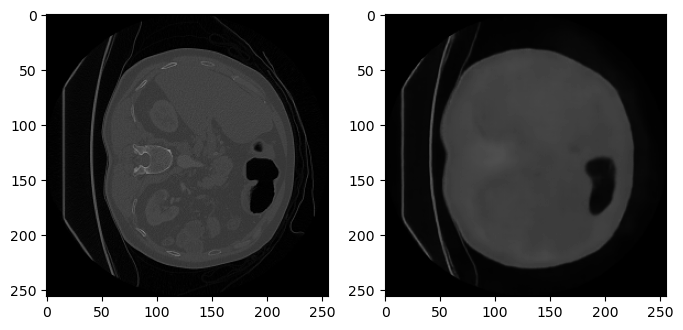

In [39]:
model.eval()
x_test = next(iter(dev_loader))[0][0].view(1, 1, 256, 256).to(device)
x_hat_test = model.forward(x_test)[0]
draw(x_test.cpu().view(1,256,256), x_hat_test.cpu().view(1,256,256))

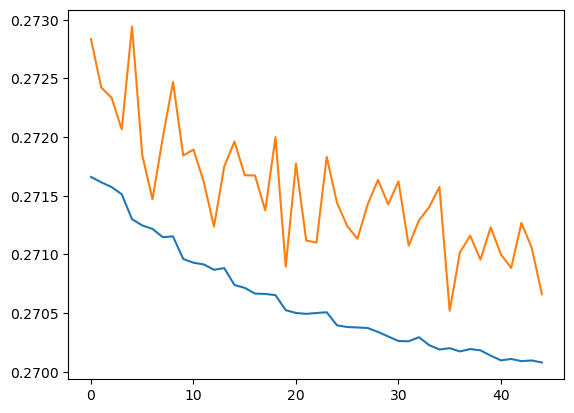

In [65]:
train_losses = torch.load('../losses/' + 'vae_train_losses.pt')
dev_losses = torch.load('../losses/' + 'vae_dev_losses.pt')
plt.plot((np.array(train_losses)))
plt.plot((np.array(dev_losses)))


In [67]:
class SegmentationModel(nn.Module):
    def __init__(self, base):
        super(SegmentationModel, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32*base, 64*base, 1),
            ConvTranspose(64*base, 4*base, 8),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 4, stride=2, padding=1),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 4, stride=2, padding=1),
            Conv(4*base, 2*base, 3, padding=1),
            ConvTranspose(2*base, 2*base, 4, stride=2, padding=1),
            Conv(2*base, 2*base, 3, padding=1),
            ConvTranspose(2*base, 2*base, 4, stride=2, padding=1),
            Conv(2*base, base, 3, padding=1),
            ConvTranspose(base, base, 4, stride=2, padding=1),
            nn.Conv2d(base, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, z):
        return self.decoder(z)

In [68]:
bce_loss = nn.BCELoss(reduction='mean')
def train_epoch(vae_model, seg_model, optimizer, train_loader):
    seg_model.train()
    vae_model.eval()
    losses = 0
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        z = vae_model.forward_latent(x)
        y_hat = seg_model.forward(z)
        loss = bce_loss(y, y_hat)
        loss.backward()
        optimizer.step()
        losses += loss.item()   
    return losses / len(train_loader)  # average loss

In [69]:
def evaluate(vae_model, seg_model, dev_loader):
    seg_model.eval()
    vae_model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        y = batch[1].to(device)
        x_hat, mu, log_var = model.forward(x)
        z = vae_model.forward_latent(x)
        y_hat = seg_model.forward(z)
        loss = bce_loss(y, y_hat)
        losses += loss.item() 
    return losses / len(dev_loader)

In [70]:
def make_seg_loaders(data, batch_size):
    N = len(data); N_train = int(0.8*N); N_dev = int((N - N_train)/2); N_test = int(N - N_train - N_dev)
    train_data, dev_data, test_data = D.random_split(data, [N_train, N_dev, N_test])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    test_loader = D.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

In [71]:
train_loader, dev_loader, test_loader = make_seg_loaders(dataset, batch_size)

In [72]:
vae_model = torch.load('../saved_models/vae_model.pt').to(device)
seg_model = SegmentationModel(base=16).to(device)
lr = 4e-3
optimizer = optim.AdamW(seg_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [73]:
total_epochs = 50

train_losses = []; dev_losses = []; lrs = []

for epoch in range(total_epochs):
    lrs.append(optimizer.param_groups[0]['lr'])
    start_time = timer()
    train_loss = train_epoch(vae_model, seg_model, optimizer, train_loader)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(vae_model, seg_model, dev_loader)
    dev_losses.append(dev_loss)
    scheduler.step()
    print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))

In [ ]:
'''' Segmentation evaluation '''
def IoU(label, recon, thresh):
    inter = ((label >= thresh) & (recon >= thresh)) * 1.0
    union = ((label >= thresh) | (recon >= thresh)) * 1.0
    return inter.sum() / union.sum() / label.shape[0]